In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)
tfd = tfp.distributions
tfb = tfp.bijectors
plt.style.use('arviz-darkgrid')

In [2]:
np.random.seed(42)
unknown_mean = -5
known_sigma = 3
data_points = 1000
data = np.random.normal(unknown_mean, known_sigma, size=data_points)
prior_mean = 4
prior_sigma = 2

# References - http://patricklam.org/teaching/conjugacy_print.pdf
precision = 1 / prior_sigma ** 2 + data_points / known_sigma ** 2
estimated_mean = (
    prior_mean / prior_sigma ** 2 + (data_points * np.mean(data) / known_sigma ** 2)
) / precision

In [3]:
tf_model = tfd.JointDistributionSequential([
    tfd.Normal(prior_mean, prior_sigma),
    lambda mu: tfd.Normal(mu, known_sigma)
])

In [4]:
def model(x):
    mu_prior = tf.math.exp(-(((x - prior_mean)/prior_sigma)**2)/2)/(np.sqrt(2*np.pi*(prior_sigma**2)))
    ll = mu_prior = tf.math.exp(-(((data - mu_prior)/known_sigma)**2)/2)/(np.sqrt(2*np.pi*(known_sigma**2)))
    return sum(map(tf.reduce_sum, [
        tf.math.log(mu_prior),
        tf.math.log(ll)
    ]))

In [5]:
joint_log_prob = lambda *samples: model(*samples)
joint_log_prob_tfp = lambda *samples: tf_model.log_prob(samples + (data,))

In [6]:
trainable_normal = tfd.Normal(
    loc=tf.Variable(tf.random.normal([], dtype=tf.float32)),
    scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), dtype=tf.float32))

opt = pm.updates.adam()

In [7]:
def loss_fn():
    samples = trainable_normal.sample()
    samples = trainable_normal.log_prob(samples) - joint_log_prob(samples)
    return tf.reduce_mean(samples)  # Monte carlo expectation

In [8]:
@tf.function(autograph=False)
def optimizer_fn():
    with tf.GradientTape() as tape:
        loss = loss_fn()

    watched_variables = tape.watched_variables()
    grads = tape.gradient(loss, watched_variables)
    train_op = opt.apply_gradients(zip(grads, watched_variables))
    with tf.control_dependencies([train_op]):
        return tf.identity(loss)

In [9]:
num_steps = 10_000
initial_loss = optimizer_fn()
traced_loss = tf.TensorArray(
    dtype=initial_loss.dtype,
    size=num_steps,
    clear_after_read=False,
    element_shape=initial_loss.shape,
)
traced_loss = traced_loss.write(0, initial_loss)

In [10]:
def loop_body(step, traced_loss):
    loss = optimizer_fn()
    traced_loss = traced_loss.write(step, loss)
    return [step+1, traced_loss]

In [11]:
with tf.control_dependencies([initial_loss]):
    indices, traced_loss = tf.while_loop(
        cond=lambda *x: True,
        body=loop_body,
        loop_vars=[1, traced_loss],
        parallel_iterations=1,
        maximum_iterations=num_steps - 1
    )

In [12]:
trainable_normal.mean()

<tf.Tensor: shape=(), dtype=float32, numpy=-4.157138>

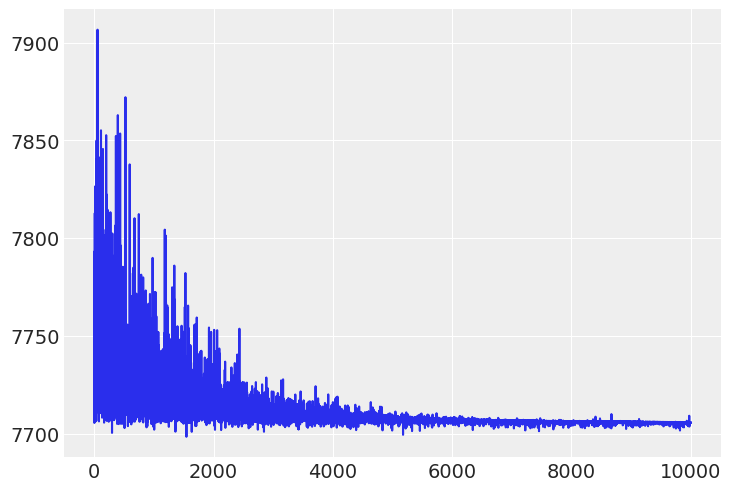

In [13]:
plt.plot(traced_loss.stack().numpy())
# plt.yscale('log')

In [15]:
estimated_mean

-4.921929491177873

In [ ]:
@pm.model
def model():
    mu = yield pm.Normal('mu', prior_mean, prior_sigma)
    ll = yield pm.Normal('ll', mu, known_sigma, observed=data)

In [ ]:
samples = advi.approximation.approx.sample(10)

In [ ]:
advi.approximation.target_log_prob(samples)

In [ ]:
advi = pm.fit(model(), sample_size=10)

In [ ]:
plt.plot(advi[1])
plt.yscale('log')

In [ ]:
mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, size=200)

In [ ]:
# Defining the model
model = tfd.JointDistributionSequential([
    # sigma_prior
    tfd.Exponential(1, name='sigma'),

    # mu_prior
    tfd.Normal(loc=0, scale=10, name='mu'),

    # likelihood
    lambda mu, sigma: tfd.Normal(loc=mu, scale=sigma)
])

In [ ]:
joint_log_prob = lambda *x: model.log_prob(x + (data,))
dtype = tf.float32

In [ ]:
# Build Mean Field ADVI
def build_mf_advi():
    parameters = model.sample(1)
    parameters.pop()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter[0].shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f'meanfield_{i}_loc',
            dtype=dtype
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(0.02, dtype=dtype)),
            tfb.Softplus(), # For positive values of scale
            name=f'meanfield_{i}_scale'
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)

meanfield_advi = build_mf_advi()

In [ ]:
unconstraining_bijectors = [
  tfb.Exp(),
  tfb.Identity()
]

posterior = make_transformed_log_prob(
    joint_log_prob,
    unconstraining_bijectors,
    direction='forward',
    enable_bijector_caching=False
)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=.1)

@tf.function(autograph=False)
def run_approximation():
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        posterior,
        surrogate_posterior=meanfield_advi,
        optimizer=opt,
        sample_size=2,
        num_steps=10000)
    return elbo_loss

elbo_loss = run_approximation()

In [ ]:
plt.plot(elbo_loss, color='blue')
plt.yscale("log")
plt.xlabel("No of iterations")
plt.ylabel("Negative ELBO")
plt.show()
